In [42]:
# import dependencies
%matplotlib inline
import json
import pandas as pd
from pandas.io.json import json_normalize
import numpy as np
import nltk
from nltk.corpus import stopwords
import gensim
from gensim.models import LdaModel
from gensim import models, corpora, similarities
import re
from nltk.stem.porter import PorterStemmer
import time
from nltk import FreqDist
from scipy.stats import entropy
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

In [148]:
content = []
with open('file.txt','r+') as doc:
    for line in doc:
        print(line)
        line=line.strip()
        with open(line,'rb') as f:
            content=f.readlines()
    

TREC_article_2012.txt

TREC_article_2013.txt

TREC_article_2014.txt

TREC_article_2015.txt

TREC_article_2016.txt

TREC_article_2017.txt

TREC_blog_2012.txt

TREC_blog_2013.txt

TREC_blog_2014.txt

TREC_blog_2015.txt

TREC_blog_2016.txt

TREC_blog_2017.txt


In [71]:
#content = []
#with open('TREC_blog_2012.txt','rb') as f:
#   content = f.readlines()
content = [json.loads(x.strip()) for x in content]
#print(content)

data = json.loads(json.dumps(content))
print(data)

content_list = []
for i in data:
    string_content = ""
    if "contents" in i:
        for all in i["contents"]:
            if "content" in all:
                # print(str(all["content"]))
                string_content = string_content + str(all["content"])
        content_list.append(string_content)


df = pd.DataFrame({'content':content_list})
print(df)
k=0

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



                                                 content
0      ExpressMonth of MuscleBy Vicky Hallett13256089...
1      ExpressMore Home Work(outs)By Vicky Hallett132...
2      ExpressFind a Place in the CrowdBy Dr. Andrea ...
3      ExpressJanuary Gym DealsBy Vicky Hallett132561...
4      ExpressPumping IronyBy Vicky Hallett1325610957...
5      ExpressStreet NonsenseBy Rudi Greenberg1325630...
6      ExpressStreet NonsenseBy Rudi Greenberg1325630...
7      ExpressSelf-Help for NerdsBy Rudi Greenberg132...
8      ExpressAlways Up For a ChangeBy Stephen M. Deu...
9      ExpressWhat the Devil?By Kristen Page-Kirby132...
10     ExpressCharacter DevelopmentBy Kristen Page-Ki...
11     ExpressOn the Spot: Eric WeinerBy Fiona Zublin...
12     ExpressWordy! Verbose! Prolix!By Katie Aberbac...
13     ExpressRejects' RevivalBy Katie Aberbach132577...
14     ExpressUncommonly GoodBy Kristen Page-Kirby132...
15     ExpressFace Time: Marc MorroneBy Express132584...
16     ExpressBoard Riffs, Owl 

In [72]:
def initial_clean(text):
    """
    Function to clean text of websites, email addresess and any punctuation
    We also lower case the text
    """
    
    text = re.sub("[^a-zA-Z ]", "", text)
    text = text.lower() # lower case the text
    text = nltk.word_tokenize(text)
    return text

stop_words = stopwords.words('english')
def remove_stop_words(text):
    """
    Function that removes all stopwords from text
    """
    return [word for word in text if word not in stop_words]

stemmer = PorterStemmer()
def stem_words(text):
    """
    Function to stem words, so plural and singular are treated the same
    """
    try:
        text = [stemmer.stem(word) for word in text]
        text = [word for word in text if len(word) > 1] # make sure we have no 1 letter words
    except IndexError: # the word "oed" broke this, so needed try except
        pass
    return text

def apply_all(text):
    """
    This function applies all the functions above into one
    """
    return stem_words(remove_stop_words(initial_clean(text)))

In [73]:
t1 = time.time()
df['tokenized'] = df['content'].apply(apply_all)
t2 = time.time()
print("Time to clean and tokenize", len(df), "articles:", (t2-t1)/60, "min")

Time to clean and tokenize 15291 articles: 4.78753897746404 min


In [84]:
# first get a list of all words
all_words = [word for item in list(df['tokenized']) for word in item]
# use nltk fdist to get a frequency distribution of all words
fdist = FreqDist(all_words)
len(fdist) # number of unique words

278785

In [90]:
# choose k and visually inspect the bottom 10 words of the top k
k = 9000
top_k_words = fdist.most_common(k)
top_k_words[-10:]

[('nonfarm', 30),
 ('idmorespanbut', 30),
 ('omit', 30),
 ('entrepreneuri', 30),
 ('withdrawn', 30),
 ('fodder', 30),
 ('liar', 30),
 ('washingtonpostcom', 30),
 ('aflcio', 30),
 ('percentbut', 30)]

In [91]:
# define a function only to keep words in the top k words
top_k_words,_ = zip(*fdist.most_common(k))
top_k_words = set(top_k_words)
def keep_top_k_words(text):
    return [word for word in text if word in top_k_words]

In [92]:
df['tokenized'] = df['tokenized'].apply(keep_top_k_words)

In [93]:
df['doc_len'] = df['tokenized'].apply(lambda x: len(x))
doc_lengths = list(df['doc_len'])
df.drop(labels='doc_len', axis=1, inplace=True)

print("length of list:",len(doc_lengths),
      "\naverage document length", np.average(doc_lengths),
      "\nminimum document length", min(doc_lengths),
      "\nmaximum document length", max(doc_lengths))

length of list: 15291 
average document length 247.77012621803675 
minimum document length 0 
maximum document length 11598


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


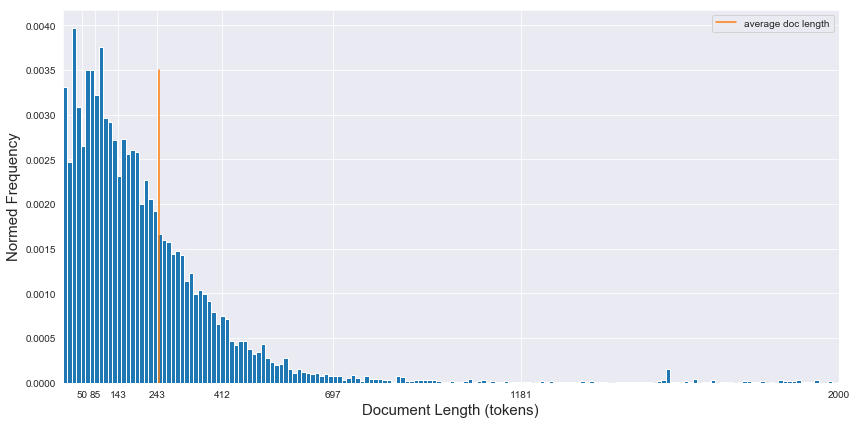

In [94]:

# plot a histogram of document length
num_bins = 1000
fig, ax = plt.subplots(figsize=(12,6));
# the histogram of the data
n, bins, patches = ax.hist(doc_lengths, num_bins, normed=1)
ax.set_xlabel('Document Length (tokens)', fontsize=15)
ax.set_ylabel('Normed Frequency', fontsize=15)
ax.grid()
ax.set_xticks(np.logspace(start=np.log10(50),stop=np.log10(2000),num=8, base=10.0))
plt.xlim(0,2000)
ax.plot([np.average(doc_lengths) for i in np.linspace(0.0,0.0035,100)], np.linspace(0.0,0.0035,100), '-',
        label='average doc length')
ax.legend()
ax.grid()
fig.tight_layout()
plt.show()

In [95]:
# only keep articles with more than 30 tokens, otherwise too short
df = df[df['tokenized'].map(len) >= 40]
# make sure all tokenized items are lists
df = df[df['tokenized'].map(type) == list]
df.reset_index(drop=True,inplace=True)
print("After cleaning and excluding short aticles, the dataframe now has:", len(df), "articles")

After cleaning and excluding short aticles, the dataframe now has: 13322 articles


In [96]:
df.head()

,content,tokenized
0,ExpressMonth of MuscleBy Vicky Hallett13256089...,"[vicki, trainer, nicol, nichol, ask, day, get,..."
1,ExpressMore Home Work(outs)By Vicky Hallett132...,"[home, vicki, train, jacki, day, fast, bodi, j..."
2,ExpressFind a Place in the CrowdBy Dr. Andrea ...,"[place, dr, andrea, feel, like, im, constantli..."
3,ExpressJanuary Gym DealsBy Vicky Hallett132561...,"[gym, vicki, quit, possibl, worst, time, year,..."
4,ExpressPumping IronyBy Vicky Hallett1325610957...,"[vicki, method, slim, involv, frozen, food, sm..."


In [97]:
# create a mask of binary values
msk = np.random.rand(len(df)) < 0.999

In [98]:
train_df = df[msk]
train_df.reset_index(drop=True,inplace=True)

test_df = df[~msk]
test_df.reset_index(drop=True,inplace=True)

In [99]:
print(len(df),len(train_df),len(test_df))

13322 13304 18


In [100]:
print(df)

                                                 content  \
0      ExpressMonth of MuscleBy Vicky Hallett13256089...   
1      ExpressMore Home Work(outs)By Vicky Hallett132...   
2      ExpressFind a Place in the CrowdBy Dr. Andrea ...   
3      ExpressJanuary Gym DealsBy Vicky Hallett132561...   
4      ExpressPumping IronyBy Vicky Hallett1325610957...   
5      ExpressStreet NonsenseBy Rudi Greenberg1325630...   
6      ExpressStreet NonsenseBy Rudi Greenberg1325630...   
7      ExpressSelf-Help for NerdsBy Rudi Greenberg132...   
8      ExpressAlways Up For a ChangeBy Stephen M. Deu...   
9      ExpressWhat the Devil?By Kristen Page-Kirby132...   
10     ExpressCharacter DevelopmentBy Kristen Page-Ki...   
11     ExpressOn the Spot: Eric WeinerBy Fiona Zublin...   
12     ExpressWordy! Verbose! Prolix!By Katie Aberbac...   
13     ExpressRejects' RevivalBy Katie Aberbach132577...   
14     ExpressUncommonly GoodBy Kristen Page-Kirby132...   
15     ExpressFace Time: Marc MorroneBy 

In [101]:
def train_lda(data):
    """
    This function trains the lda model
    We setup parameters like number of topics, the chunksize to use in Hoffman method
    We also do 2 passes of the data since this is a small dataset, so we want the distributions to stabilize
    """
    num_topics = 100
    chunksize = 300
    dictionary = corpora.Dictionary(data['tokenized'])
    corpus = [dictionary.doc2bow(doc) for doc in data['tokenized']]
    t1 = time.time()
    # low alpha means each document is only represented by a small number of topics, and vice versa
    # low eta means each topic is only represented by a small number of words, and vice versa
    lda = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary,
                   alpha=1e-2, eta=0.5e-2, chunksize=chunksize, minimum_probability=0.0, passes=2)
    t2 = time.time()
    print("Time to train LDA model on ", len(df), "articles: ", (t2-t1)/60, "min")
    return dictionary,corpus,lda

In [102]:
dictionary,corpus,lda = train_lda(train_df)

Time to train LDA model on  13322 articles:  2.3500609278678892 min


In [103]:
# show_topics method shows the the top num_words contributing to num_topics number of random topics
lda.show_topics(num_topics=10, num_words=20)

[(65,
  '0.116*"economi" + 0.071*"debat" + 0.050*"presidenti" + 0.025*"polit" + 0.014*"social" + 0.014*"time" + 0.013*"think" + 0.013*"today" + 0.012*"talk" + 0.012*"highli" + 0.011*"second" + 0.011*"news" + 0.011*"us" + 0.011*"first" + 0.010*"facebook" + 0.009*"discuss" + 0.009*"last" + 0.008*"term" + 0.008*"moment" + 0.008*"impact"'),
 (75,
  '0.062*"sunday" + 0.047*"monday" + 0.042*"news" + 0.041*"new" + 0.039*"york" + 0.030*"confer" + 0.029*"post" + 0.024*"report" + 0.022*"announc" + 0.021*"mike" + 0.018*"suffer" + 0.017*"morn" + 0.016*"host" + 0.016*"afternoon" + 0.015*"meet" + 0.012*"threaten" + 0.012*"morgan" + 0.012*"incid" + 0.011*"interview" + 0.011*"pro"'),
 (43,
  '0.119*"win" + 0.094*"game" + 0.030*"east" + 0.025*"team" + 0.024*"span" + 0.021*"first" + 0.020*"lose" + 0.020*"lead" + 0.019*"dan" + 0.018*"finish" + 0.017*"beat" + 0.015*"record" + 0.014*"titl" + 0.014*"tie" + 0.013*"sport" + 0.013*"chanc" + 0.013*"three" + 0.012*"award" + 0.012*"sunday" + 0.011*"second"'),
 (5

In [105]:
lda.show_topic(topicid=85, topn=20)

[('obama', 0.24887075),
 ('presid', 0.17353348),
 ('white', 0.05953011),
 ('hous', 0.04261489),
 ('clinton', 0.042233687),
 ('ad', 0.01827835),
 ('john', 0.013371213),
 ('american', 0.012922388),
 ('attack', 0.012455684),
 ('ezra', 0.01120827),
 ('barack', 0.011185646),
 ('campaign', 0.010341723),
 ('say', 0.010113728),
 ('press', 0.009826403),
 ('tuesday', 0.0093497615),
 ('talk', 0.009024382),
 ('polit', 0.008715999),
 ('new', 0.008258153),
 ('clear', 0.007409679),
 ('four', 0.007314558)]

In [106]:
lda.show_topic(topicid=75, topn=20)

[('sunday', 0.06213536),
 ('monday', 0.046883617),
 ('news', 0.04195037),
 ('new', 0.04112747),
 ('york', 0.039213676),
 ('confer', 0.029924309),
 ('post', 0.02861682),
 ('report', 0.023610873),
 ('announc', 0.022387983),
 ('mike', 0.020601342),
 ('suffer', 0.017634014),
 ('morn', 0.016708434),
 ('host', 0.015854016),
 ('afternoon', 0.015618858),
 ('meet', 0.015267099),
 ('threaten', 0.012331498),
 ('morgan', 0.012191579),
 ('incid', 0.011801389),
 ('interview', 0.0109606),
 ('pro', 0.010605792)]

In [108]:
# select and article at random from train_df
print (train_df)
random_article_index = np.random.randint(len(train_df))
bow = dictionary.doc2bow(train_df.iloc[random_article_index,1])

                                                 content  \
0      ExpressMonth of MuscleBy Vicky Hallett13256089...   
1      ExpressMore Home Work(outs)By Vicky Hallett132...   
2      ExpressFind a Place in the CrowdBy Dr. Andrea ...   
3      ExpressJanuary Gym DealsBy Vicky Hallett132561...   
4      ExpressPumping IronyBy Vicky Hallett1325610957...   
5      ExpressStreet NonsenseBy Rudi Greenberg1325630...   
6      ExpressStreet NonsenseBy Rudi Greenberg1325630...   
7      ExpressSelf-Help for NerdsBy Rudi Greenberg132...   
8      ExpressAlways Up For a ChangeBy Stephen M. Deu...   
9      ExpressWhat the Devil?By Kristen Page-Kirby132...   
10     ExpressCharacter DevelopmentBy Kristen Page-Ki...   
11     ExpressOn the Spot: Eric WeinerBy Fiona Zublin...   
12     ExpressWordy! Verbose! Prolix!By Katie Aberbac...   
13     ExpressRejects' RevivalBy Katie Aberbach132577...   
14     ExpressUncommonly GoodBy Kristen Page-Kirby132...   
15     ExpressFace Time: Marc MorroneBy 

In [109]:
print(train_df.iloc[random_article_index,1])

['district', 'dc', 'onlin', 'absente', 'ballot', 'request', 'form', 'mike', 'littl', 'three', 'week', 'remain', 'deadlin', 'dc', 'resid', 'request', 'absente', 'ballot', 'nov', 'elect', 'need', 'current', 'unabl', 'absente', 'board', 'elect', 'web', 'onlin', 'absente', 'function', 'give', 'user', 'error', 'tri', 'display', 'person', 'applic', 'form', 'url', 'valid', 'pleas', 'tri', 'resid', 'contact', 'said', 'function', 'day', 'altern', 'haul', 'board', 'offic', 'one', 'judiciari', 'squar', 'william', 'said', 'board', 'staff', 'awar', 'work', 'resolv', 'yet', 'respond', 'question', 'long', 'fix', 'might', 'ballot', 'applic', 'must', 'receiv', 'board', 'oct', 'onlin', 'function', 'use', 'onlin', 'form', 'popul', 'pdf', 'file', 'still', 'must', 'print', 'mail', 'board', 'might', 'suggest', 'easi', 'fix', 'ditch', 'featur', 'post', 'blank', 'pmstrong', 'even', 'wors', 'first', 'indic', 'absente', 'ballot', 'function', 'broken', 'form', 'regist', 'vote', 'updat', 'registr', 'also', 'broke

In [110]:
# get the topic contributions for the document chosen at random above
doc_distribution = np.array([tup[1] for tup in lda.get_document_topics(bow=bow)])

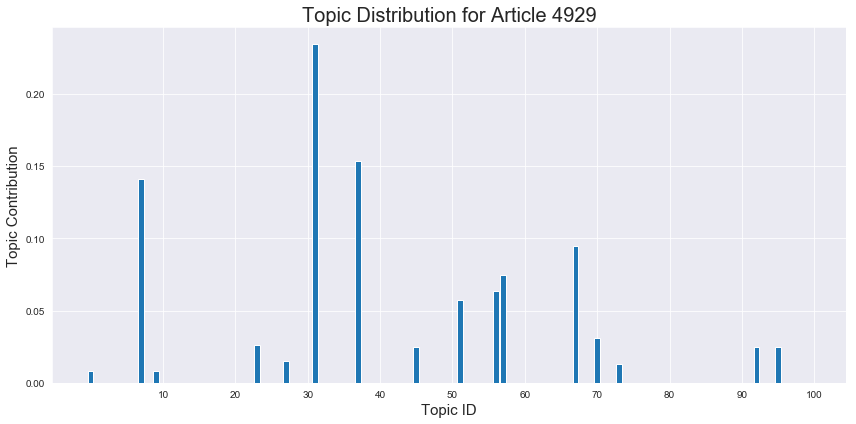

In [111]:
# bar plot of topic distribution for this document
fig, ax = plt.subplots(figsize=(12,6));
# the histogram of the data
patches = ax.bar(np.arange(len(doc_distribution)), doc_distribution)
ax.set_xlabel('Topic ID', fontsize=15)
ax.set_ylabel('Topic Contribution', fontsize=15)
ax.set_title("Topic Distribution for Article " + str(random_article_index), fontsize=20)
ax.set_xticks(np.linspace(10,100,10))
fig.tight_layout()
plt.show()

In [112]:
# print the top 5 contributing topics and their words
for i in doc_distribution.argsort()[-5:][::-1]:
    print(i, lda.show_topic(topicid=i, topn=10), "\n")

31 [('year', 0.011270009), ('new', 0.009736547), ('us', 0.008032987), ('use', 0.007563862), ('would', 0.0073378053), ('assault', 0.006781358), ('data', 0.006501206), ('compromis', 0.006128381), ('may', 0.005965141), ('could', 0.005914112)] 

37 [('would', 0.04219999), ('one', 0.014852472), ('like', 0.013893044), ('even', 0.013502857), ('make', 0.012557653), ('could', 0.012311041), ('say', 0.011327057), ('voter', 0.00862586), ('right', 0.008143847), ('much', 0.007574571)] 

7 [('percent', 0.072026), ('vote', 0.06857191), ('state', 0.037967615), ('among', 0.015036519), ('number', 0.013106302), ('new', 0.012905945), ('show', 0.012758089), ('like', 0.012128837), ('major', 0.011957468), ('obama', 0.010475379)] 

67 [('congress', 0.09602123), ('debt', 0.08525257), ('propos', 0.051787805), ('plan', 0.05026377), ('rule', 0.02662527), ('member', 0.023449948), ('meet', 0.021981701), ('presid', 0.020512866), ('board', 0.018201351), ('would', 0.015614379)] 

57 [('elect', 0.065584235), ('campaign'

In [113]:
# select and article at random from test_df
len(test_df)
random_article_index = np.random.randint(len(test_df))
print(random_article_index)

16


In [114]:
new_bow = dictionary.doc2bow(test_df.iloc[random_article_index,1])

In [115]:
print(test_df.iloc[random_article_index,1])

['feder', 'debut', 'eric', 'main', 'inform', 'benefit', 'launch', 'youtubea', 'initi', 'video', 'use', 'site', 'recommend', 'site', 'visitor', 'investig', 'benefit', 'may', 'qualifi', 'inform', 'hand', 'regard', 'famili', 'educ', 'career', 'incom', 'current', 'benefit', 'receiv', 'also', 'recommend', 'answer', 'mani', 'question', 'possibl', 'even', 'respons', 'option', 'best', 'determin', 'note', 'benefit', 'may', 'avail', 'famili', 'member', 'one', 'militari', 'veteran', 'featur', 'includ', 'email', 'updat', 'program', 'site', 'featur', 'previous', 'establish', 'presenc']


In [116]:
new_doc_distribution = np.array([tup[1] for tup in lda.get_document_topics(bow=new_bow)])

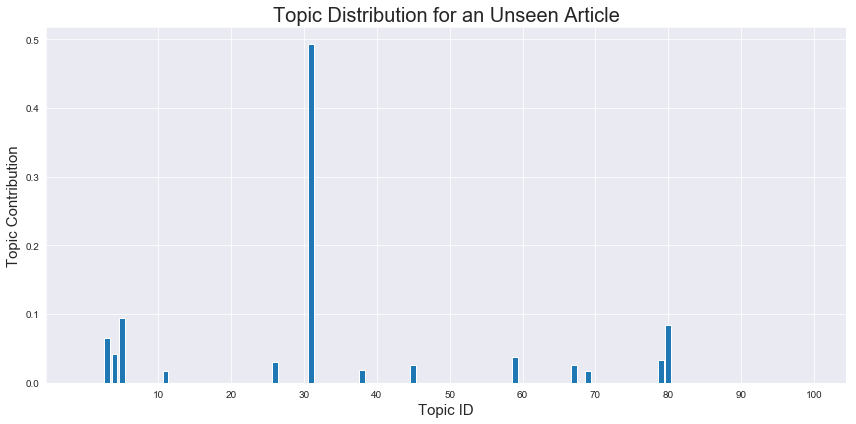

In [117]:
# bar plot of topic distribution for this document
fig, ax = plt.subplots(figsize=(12,6));
# the histogram of the data
patches = ax.bar(np.arange(len(new_doc_distribution)), new_doc_distribution)
ax.set_xlabel('Topic ID', fontsize=15)
ax.set_ylabel('Topic Contribution', fontsize=15)
ax.set_title("Topic Distribution for an Unseen Article", fontsize=20)
ax.set_xticks(np.linspace(10,100,10))
fig.tight_layout()
plt.show()

In [126]:
# print the top 8 contributing topics and their words
for i in new_doc_distribution.argsort()[-10:][::-1]:
    print(i, lda.show_topic(topicid=i, topn=10), "\n")

31 [('year', 0.011270009), ('new', 0.009736547), ('us', 0.008032987), ('use', 0.007563862), ('would', 0.0073378053), ('assault', 0.006781358), ('data', 0.006501206), ('compromis', 0.006128381), ('may', 0.005965141), ('could', 0.005914112)] 

5 [('health', 0.14814451), ('law', 0.094460875), ('care', 0.08991048), ('doctor', 0.042856213), ('medic', 0.0380091), ('hospit', 0.03648955), ('afford', 0.031693146), ('cost', 0.025716305), ('benefit', 0.024496898), ('treatment', 0.020304816)] 

80 [('feder', 0.054281473), ('state', 0.04872759), ('govern', 0.042264838), ('secur', 0.036886234), ('administr', 0.023794074), ('program', 0.021981915), ('social', 0.018941257), ('depart', 0.015019455), ('law', 0.013917707), ('intern', 0.012199547)] 

3 [('season', 0.024451772), ('year', 0.022729669), ('run', 0.021758134), ('like', 0.017416492), ('time', 0.016637132), ('he', 0.016319953), ('good', 0.015880434), ('start', 0.01561845), ('got', 0.0140726585), ('fan', 0.013029495)] 

4 [('cut', 0.080446534), (

In [135]:
# we need to use nested list comprehension here
# this may take 1-2 minutes...
doc_topic_dist = np.array([[tup[1] for tup in lst] for lst in lda[corpus]])
doc_topic_dist.shape
print(doc_topic_dist)

[[4.6539571e-05 4.6539571e-05 4.6539571e-05 ... 4.6539571e-05
  4.6539571e-05 4.6539571e-05]
 [9.5321455e-05 9.5321455e-05 9.5321455e-05 ... 9.5321455e-05
  9.5321455e-05 9.5321455e-05]
 [5.7826583e-05 5.9565804e-03 5.7826583e-05 ... 5.7826583e-05
  5.7826583e-05 5.7826583e-05]
 ...
 [1.3160636e-04 1.3160636e-04 1.3160636e-04 ... 1.3160636e-04
  1.3160636e-04 1.3160636e-04]
 [1.4288403e-04 1.4288403e-04 1.4288403e-04 ... 1.4288403e-04
  1.4288403e-04 1.4288403e-04]
 [7.0378050e-02 2.0411547e-04 2.0411547e-04 ... 2.0411547e-04
  2.0411547e-04 2.0411547e-04]]


In [120]:
def jensen_shannon(query, matrix):
    """
    This function implements a Jensen-Shannon similarity
    between the input query (an LDA topic distribution for a document)
    and the entire corpus of topic distributions.
    It returns an array of length M where M is the number of documents in the corpus
    """
    # lets keep with the p,q notation above
    p = query[None,:].T # take transpose
    q = matrix.T # transpose matrix
    m = 0.5*(p + q)
    return np.sqrt(0.5*(entropy(p,m) + entropy(q,m)))

In [121]:
def get_most_similar_documents(query,matrix,k=10):
    """
    This function implements the Jensen-Shannon distance above
    and retruns the top k indices of the smallest jensen shannon distances
    """
    sims = jensen_shannon(query,matrix) # list of jensen shannon distances
    return sims.argsort()[:k] # the top k positional index of the smallest Jensen Shannon distances

In [122]:
# this is surprisingly fast
most_sim_ids = get_most_similar_documents(new_doc_distribution,doc_topic_dist)

In [140]:
print(most_sim_ids)
most_similar_df = train_df[train_df.index.isin(most_sim_ids)]
print (most_similar_df)

[11553  3323  1187 11728  8797 11143  4370  4163  2333  2305]
                                                 content  \
1187   WonkblogMarten Gilens’s ‘Affluence and Influen...   
2305   Post PoliticsBoehner factcheckedBy Glenn Kessl...   
2333   Post PoliticsFact Check: Rick Santorum on welf...   
3323   WonkblogCongressional Research Service: Obama’...   
4163   Maryland TerrapinsMaryland releases five-year ...   
4370   WonkblogMissouri court: Yes, the feds can mand...   
8797   WonkblogIs Obamacare too much work for the Oba...   
11143  Right TurnU.S. Senate stands up for human righ...   
11553  WorldViewsHow did North Korea fix its rocket p...   
11728  Federal InsiderLocal House members oppose pote...   

                                               tokenized  
1187   [ezra, kleina, influenc, econom, inequ, polit,...  
2305   [post, glenn, stylefontfamili, default, time, ...  
2333   [post, politicsfact, check, rick, santorum, we...  
3323   [research, servic, obama, welfar, 